In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
import shap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
file_path = '/content/Fraudulent_E-Commerce_Transaction_Data_2.csv'
data = pd.read_csv(file_path)


data.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,8ca9f102-02a4-4207-ab63-484e83a1bdf0,42.32,2024-03-24 23:42:43,PayPal,electronics,1,40,East Jameshaven,desktop,110.87.246.85,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,5399 Rachel Stravenue Suite 718\nNorth Blakebu...,0,282,23
1,7d187603-7961-4fce-9827-9698e2b6a201,4d158416-caae-4b09-bd5b-15235deb9129,301.34,2024-01-22 00:53:31,credit card,electronics,3,35,Kingstad,tablet,14.73.104.153,"5230 Stephanie Forge\nCollinsbury, PR 81853","5230 Stephanie Forge\nCollinsbury, PR 81853",0,223,0
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,ccae47b8-75c7-4f5a-aa9e-957deced2137,340.32,2024-01-22 08:06:03,debit card,toys & games,5,29,North Ryan,desktop,67.58.94.93,"195 Cole Oval\nPort Larry, IA 58422","4772 David Stravenue Apt. 447\nVelasquezside, ...",0,360,8
3,e9949bfa-194d-486b-84da-9565fca9e5ce,b04960c0-aeee-4907-b1cd-4819016adcef,95.77,2024-01-16 20:34:53,credit card,electronics,5,45,Kaylaville,mobile,202.122.126.216,"7609 Cynthia Square\nWest Brenda, NV 23016","7609 Cynthia Square\nWest Brenda, NV 23016",0,325,20
4,7362837c-7538-434e-8731-0df713f5f26d,de9d6351-b3a7-4bc7-9a55-8f013eb66928,77.45,2024-01-16 15:47:23,credit card,clothing,5,42,North Edwardborough,desktop,96.77.232.76,"2494 Robert Ramp Suite 313\nRobinsonport, AS 5...","2494 Robert Ramp Suite 313\nRobinsonport, AS 5...",0,116,15


In [3]:
shape = data.shape
data_types = data.dtypes
summary_stats = data.describe()
missing_values = data.isnull().sum()
unique_values = data.select_dtypes(include=['object', 'category']).nunique()
target_value_counts = data['Is Fraudulent'].value_counts(normalize=True)

print(shape, data_types, summary_stats, missing_values, unique_values, target_value_counts)

(23634, 16) Transaction ID         object
Customer ID            object
Transaction Amount    float64
Transaction Date       object
Payment Method         object
Product Category       object
Quantity                int64
Customer Age            int64
Customer Location      object
Device Used            object
IP Address             object
Shipping Address       object
Billing Address        object
Is Fraudulent           int64
Account Age Days        int64
Transaction Hour        int64
dtype: object        Transaction Amount      Quantity  Customer Age  Is Fraudulent  \
count        23634.000000  23634.000000  23634.000000   23634.000000   
mean           229.367099      3.000550     34.560210       0.051705   
std            282.046669      1.419663     10.009471       0.221436   
min             10.000000      1.000000     -2.000000       0.000000   
25%             69.070000      2.000000     28.000000       0.000000   
50%            151.415000      3.000000     35.000000       0.

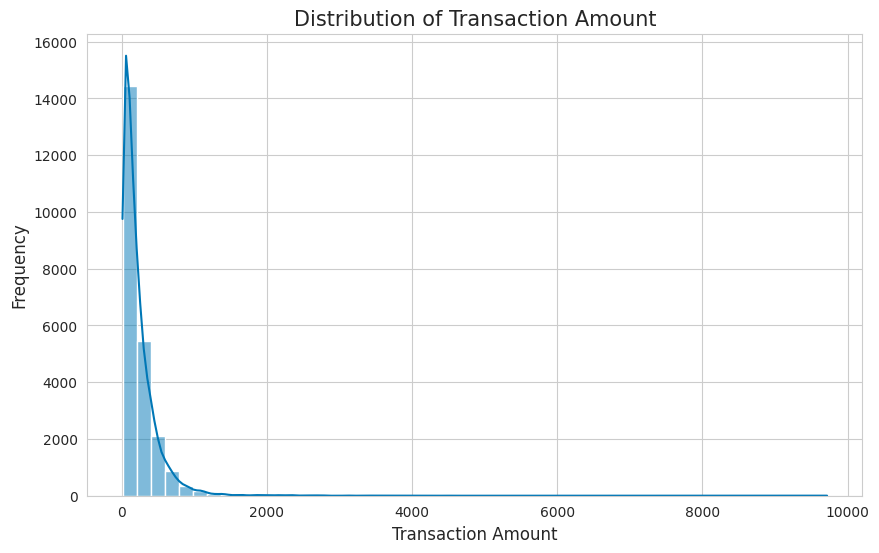

In [4]:
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))
sns.histplot(data['Transaction Amount'], bins=50, kde=True, color='#0077B6')
plt.title('Distribution of Transaction Amount', fontsize=15)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


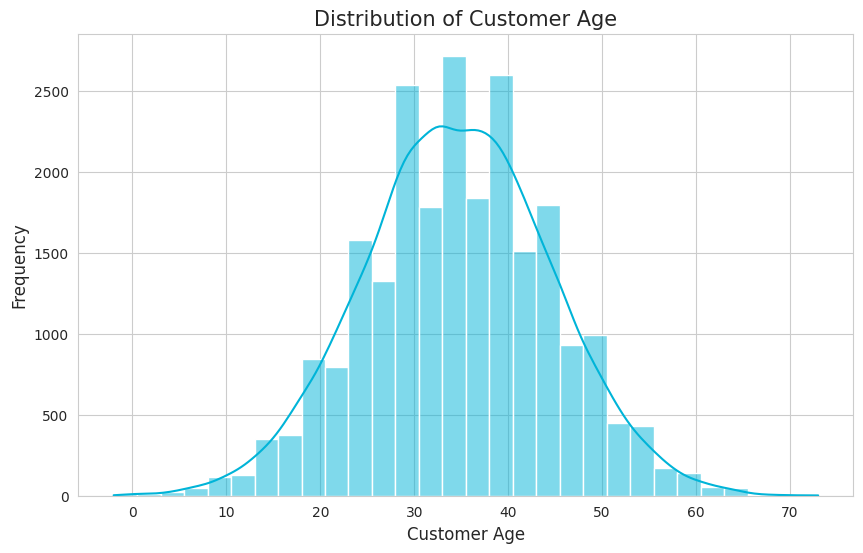

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(data['Customer Age'], bins=30, kde=True, color='#00B4D8')
plt.title('Distribution of Customer Age', fontsize=15)
plt.xlabel('Customer Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

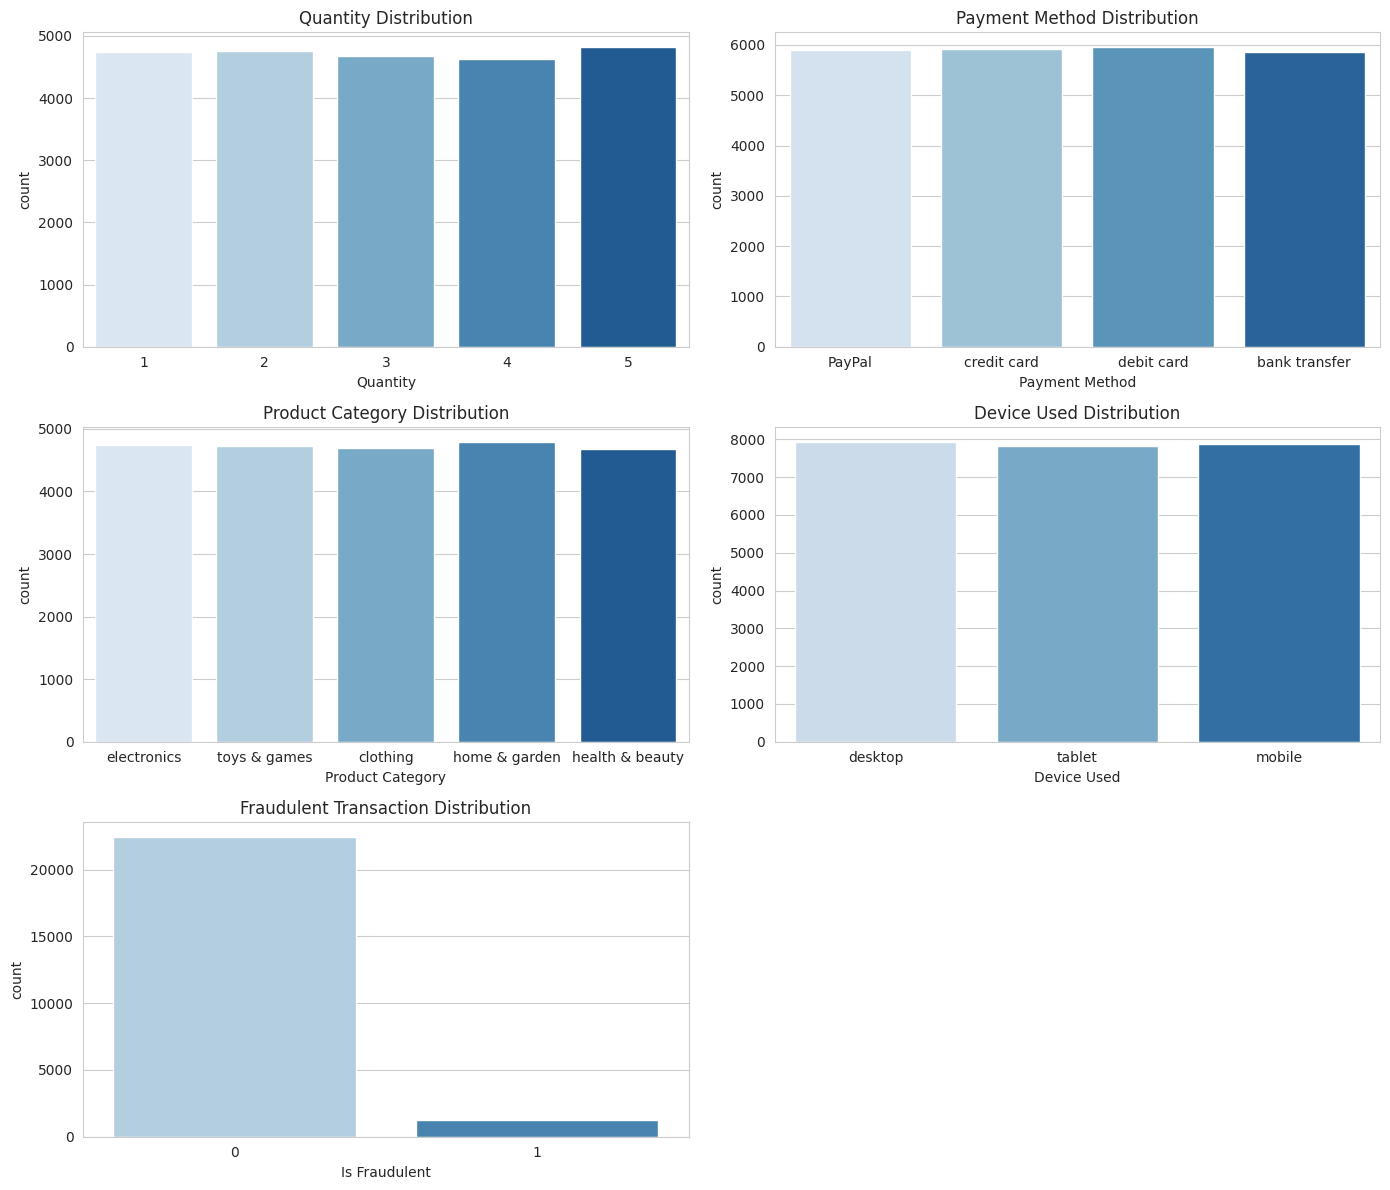

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

sns.countplot(x=data['Quantity'], palette='Blues', ax=axs[0,0])
axs[0,0].set(title='Quantity Distribution')

sns.countplot(x=data['Payment Method'], palette='Blues', ax=axs[0,1])
axs[0,1].set(title='Payment Method Distribution')

sns.countplot(x=data['Product Category'], palette='Blues', ax=axs[1,0])
axs[1,0].set(title='Product Category Distribution')

sns.countplot(x=data['Device Used'], palette='Blues', ax=axs[1,1])
axs[1,1].set(title='Device Used Distribution')

sns.countplot(x=data['Is Fraudulent'], palette='Blues', ax=axs[2,0])
axs[2,0].set(title='Fraudulent Transaction Distribution')

axs[2,1].axis('off')

plt.tight_layout()
plt.show()


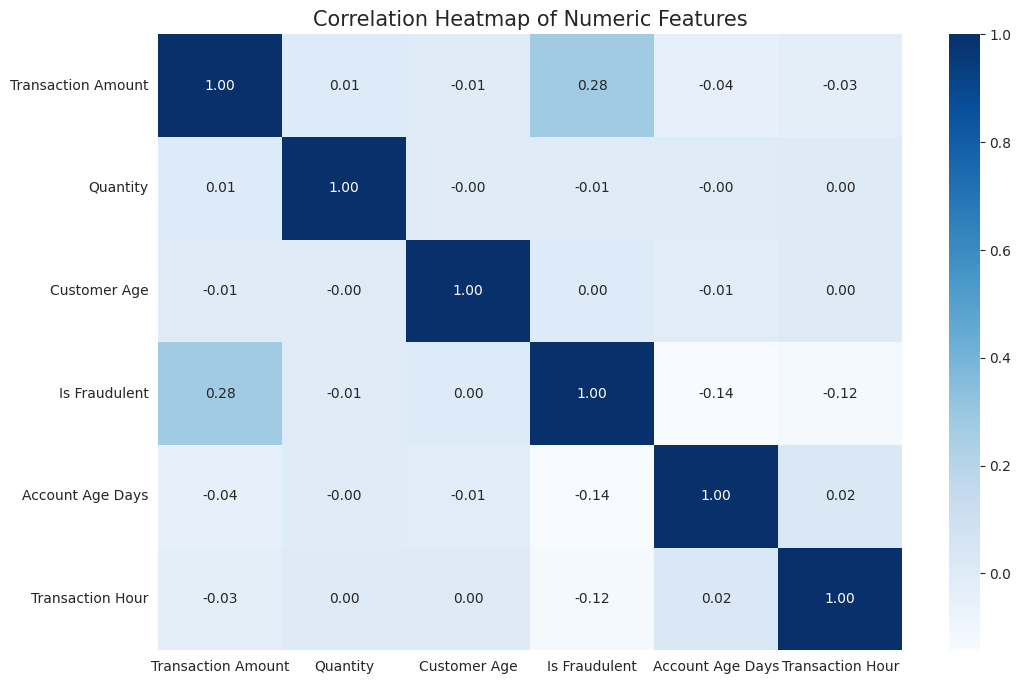

In [7]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features', fontsize=15)
plt.show()


In [8]:
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])
data['Transaction_Weekday'] = data['Transaction Date'].dt.dayofweek
data['Transaction_Hour'] = data['Transaction Date'].dt.hour
data['Address_Mismatch'] = (data['Shipping Address'] != data['Billing Address']).astype(int)
customer_freq = data['Customer ID'].value_counts().to_dict()
data['Customer_Frequency'] = data['Customer ID'].map(customer_freq)
customer_avg_amount = data.groupby('Customer ID')['Transaction Amount'].transform('mean')
data['Avg_Transaction_Amount'] = customer_avg_amount
data['Amount_to_Avg_Ratio'] = data['Transaction Amount'] / data['Avg_Transaction_Amount']
category_avg_amount = data.groupby('Product Category')['Transaction Amount'].transform('mean')
data['Amount_Higher_Than_Average'] = (data['Transaction Amount'] > category_avg_amount).astype(int)
category_avg_qty = data.groupby('Product Category')['Quantity'].transform('mean')
data['Quantity_vs_Category_Avg'] = data['Quantity'] / category_avg_qty
median_amount = data['Transaction Amount'].median()
data['High_Value_Transaction'] = (data['Transaction Amount'] > 3*median_amount).astype(int)
data['Odd_Hour_Transaction'] = ((data['Transaction_Hour'] >= 0) & (data['Transaction_Hour'] <= 5)).astype(int)
data['Weekend_Transaction'] = (data['Transaction_Weekday'] >= 5).astype(int)
data['Amount_x_CustomerFreq'] = data['Transaction Amount'] * data['Customer_Frequency']
data['Payment_Device_Interaction'] = data['Payment Method'].astype(str) + "_" + data['Device Used'].astype(str)
data = data.sort_values(by=['Customer ID', 'Transaction Date'])
data['Days_Since_Last_Transaction'] = data.groupby('Customer ID')['Transaction Date'].diff().dt.days.fillna(0)

feature_cols = ['Address_Mismatch','Transaction_Weekday','Transaction_Hour','Customer_Frequency',
                'Avg_Transaction_Amount','Amount_to_Avg_Ratio','Amount_Higher_Than_Average',
                'Quantity_vs_Category_Avg','High_Value_Transaction','Odd_Hour_Transaction',
                'Weekend_Transaction','Amount_x_CustomerFreq','Days_Since_Last_Transaction',
                'Payment_Device_Interaction']
data[feature_cols].head()

,Address_Mismatch,Transaction_Weekday,Transaction_Hour,Customer_Frequency,Avg_Transaction_Amount,Amount_to_Avg_Ratio,Amount_Higher_Than_Average,Quantity_vs_Category_Avg,High_Value_Transaction,Odd_Hour_Transaction,Weekend_Transaction,Amount_x_CustomerFreq,Days_Since_Last_Transaction,Payment_Device_Interaction
20353,0,2,21,1,1876.05,1.0,1,1.672491,1,0,0,1876.05,0.0,credit card_desktop
19910,0,0,8,1,43.68,1.0,0,0.337768,0,0,0,43.68,0.0,credit card_desktop
1906,0,6,17,1,141.40,1.0,0,1.677256,0,0,1,141.40,0.0,credit card_tablet
10986,0,3,19,1,143.46,1.0,0,1.307719,0,0,0,143.46,0.0,credit card_tablet
20471,0,1,5,1,246.12,1.0,1,0.995999,0,1,0,246.12,0.0,bank transfer_tablet


In [9]:
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

X = data[feature_cols]
y = data['Is Fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)

def make_cols_unique(df):
    cols = pd.Series(df.columns)
    for dup in df.columns[df.columns.duplicated(keep=False)]:
        dups = cols[cols == dup].index.tolist()
        for i, idx in enumerate(dups):
            if i != 0:
                cols[idx] = f"{dup}_{i}"
    df.columns = cols
    return df

X_train_res = make_cols_unique(X_train_res)
X_test = make_cols_unique(X_test)

xgb_model = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                          scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
                          random_state=42, eval_metric='logloss')

lgbm_model = LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1,
                            class_weight='balanced', random_state=42)

cat_model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1,
                               eval_metric='F1', random_state=42, verbose=0)

estimators = [('xgb', xgb_model), ('lgbm', lgbm_model), ('cat', cat_model)]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42),
    cv=5
)

stack_model.fit(X_train_res, y_train_res)

y_pred = stack_model.predict(X_test)
y_pred_proba = stack_model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 16159, number of negative: 12089
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 28248, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

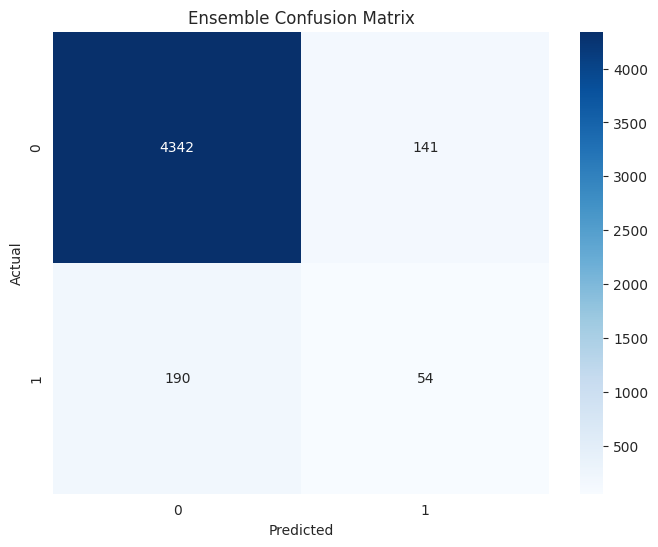

ROC-AUC: 0.556
PR-AUC: 0.211


In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Ensemble Confusion Matrix')
plt.show()

roc_score = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"ROC-AUC: {roc_score:.3f}")
print(f"PR-AUC: {pr_auc:.3f}")

explainer = shap.Explainer(stack_model.final_estimator_)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)